### Prediction Model

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load Data
df = pd.read_csv("./data/student-habits/student_performance_large_dataset.csv")

In [42]:
df

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


### Preprocess Data

In [43]:
# Separate features and target
X = df.drop(columns=["student_id", "exam_score"])  # exclude ID and target
y = df["exam_score"]

Build a pipeline to train the model

In [44]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != "student_id"]
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

Train the model

In [45]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate
preds = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
print(f"RMSE: {rmse:.2f}")

RMSE: 6.23


Try a few other models like RandomForest and GradientBoost

In [46]:
# Split features and target
X = df.drop(columns=["student_id", "exam_score"])  # exclude ID and target
y = df["exam_score"]

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != "student_id"]
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}

results = {}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through models
for name, mp in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])
    
    grid = GridSearchCV(pipeline, mp['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    
    results[name] = {
        'best_params': grid.best_params_,
        'rmse': rmse
    }

# Print results
for model_name, result in results.items():
    print(f"{model_name} -> RMSE: {result['rmse']:.2f}, Best Params: {result['best_params']}")


RandomForest -> RMSE: 6.23, Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
GradientBoosting -> RMSE: 5.60, Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200}


### Analyse Feature Importance

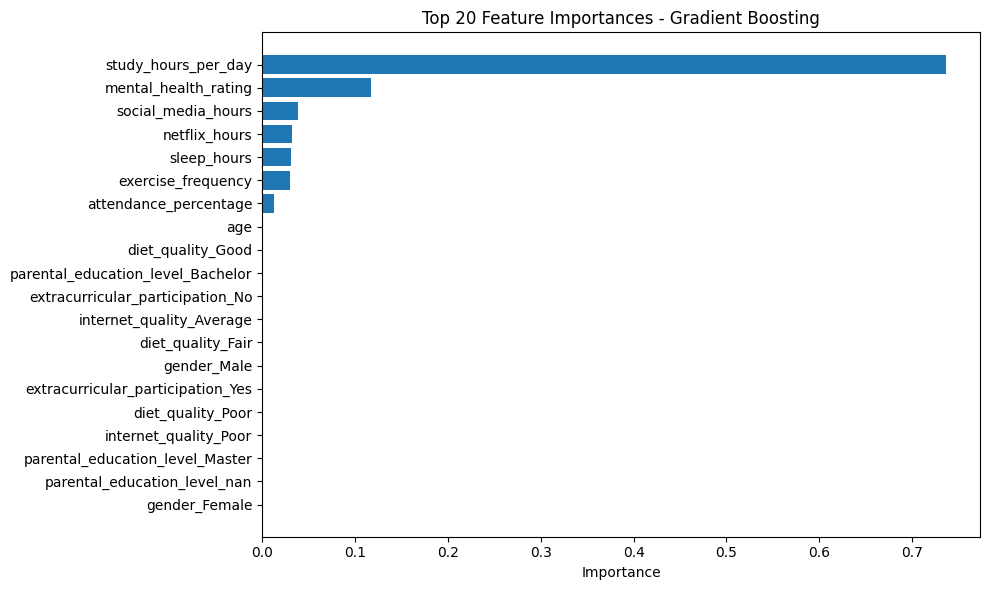

In [47]:
# Best model from GridSearchCV
best_gbr = grid.best_estimator_

# Get feature names after preprocessing
cat_features = best_gbr.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, cat_features])

# Get importances
importances = best_gbr.named_steps['model'].feature_importances_

# Number of top features to show
TOP_N = 20

# Sort and get top N
indices = np.argsort(importances)[::-1][:TOP_N]
sorted_features = all_features[indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title(f"Top {TOP_N} Feature Importances - Gradient Boosting")
plt.barh(range(TOP_N), sorted_importances, align='center')
plt.yticks(range(TOP_N), sorted_features)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


It seems that study hours are a dominant feature. We remove it and see if the model generalizes better.

In [48]:
# Split features and target
X = df.drop(columns=["student_id", "exam_score", "study_hours_per_day"])
y = df["exam_score"]

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != "student_id"]
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != "study_hours_per_day"]


# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Define models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}

results = {}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop through models
for name, mp in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])
    
    grid = GridSearchCV(pipeline, mp['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    
    results[name] = {
        'best_params': grid.best_params_,
        'rmse': rmse
    }

# Print results
for model_name, result in results.items():
    print(f"{model_name} -> RMSE: {result['rmse']:.2f}, Best Params: {result['best_params']}")

RandomForest -> RMSE: 15.53, Best Params: {'model__max_depth': 10, 'model__n_estimators': 100}
GradientBoosting -> RMSE: 15.48, Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


Model performs way worse without study hours, so include it.

# Actual Prediction Model

In [15]:
# Train data only on 6 most important features
X = df[["study_hours_per_day", 
        "mental_health_rating", 
        "social_media_hours", 
        "netflix_hours", 
        "sleep_hours", 
        "exercise_frequency",
        "attendance_percentage"]]
y = df["exam_score"]

# Identify column types
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use optimal parameters from grid search
model = GradientBoostingRegressor(learning_rate=0.05, max_depth=3, n_estimators=200)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
print("RMSE: ", rmse)

RMSE:  5.62699805849327


Predict own score based on trained model.

In [23]:
# Define your own sample
new_sample = pd.DataFrame({
    "study_hours_per_day": [9],  # Example: 5 hours per day
    "mental_health_rating": [7],  # Example: Rating of 7
    "social_media_hours": [2],  # Example: 2 hours of social media usage
    "netflix_hours": [7],  # Example: 1 hour of Netflix usage
    "sleep_hours": [7],  # Example: 7 hours of sleep
    "exercise_frequency": [3],  # Example: Exercise 3 times a week
    "attendance_percentage": [90]  # Example: 90% attendance
})

# Make prediction using the trained pipeline
predicted_exam_score = pipeline.predict(new_sample)

print("Predicted exam score:", predicted_exam_score)


Predicted exam score: [95.88877071]


### Save the model

In [ ]:
import joblib

# Save the trained pipeline (model + preprocessor)
joblib.dump(pipeline, 'models/prediction_model.pkl')

['models/prediction_model.pkl']